In [93]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

##Load data

In [94]:
df = pd.read_csv('/content/aggregate_median_jams_Kota Banjar.csv', parse_dates=['time'])
df.head()

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry
0,2022-07-06 02:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,2201.0,84.0,29.779999,6,33489989,2022-07-06,1.0,"MULTILINESTRING ((108.470602 -7.350802, 108.47..."
1,2022-07-06 06:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,87.0,10.670000,1,33489990,2022-07-06,3.0,"LINESTRING (108.541986 -7.369257, 108.541931 -..."
2,2022-07-06 07:00:00,32.79,KOTA BANJAR,N15 Siliwangi,2,1637.0,110.0,27.110000,7,33489992,2022-07-06,2.0,"MULTILINESTRING ((108.566017 -7.359884, 108.56..."
3,2022-07-06 07:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,65.5,12.035000,2,33489991,2022-07-06,3.0,"LINESTRING (108.541068 -7.374205, 108.541374 -..."
4,2022-07-06 09:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,2,501.0,63.5,12.705000,2,33489995,2022-07-06,2.0,"LINESTRING (108.541931 -7.369831, 108.541986 -..."


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   time                       1550 non-null   datetime64[ns]
 1   kemendagri_kabupaten_kode  1550 non-null   float64       
 2   kemendagri_kabupaten_nama  1550 non-null   object        
 3   street                     1386 non-null   object        
 4   level                      1550 non-null   int64         
 5   median_length              1550 non-null   float64       
 6   median_delay               1550 non-null   float64       
 7   median_speed_kmh           1550 non-null   float64       
 8   total_records              1550 non-null   int64         
 9   id                         1550 non-null   int64         
 10  date                       1550 non-null   object        
 11  median_level               1550 non-null   float64       
 12  geomet

* Data kemacetan di Kota Banjar terdiri dari 13 kolom dan 1550 baris
* Kolom `street` memiliki null
* Categorical: `kemendagri_kabupaten_kode`, `kemendagri_kabupaten_nama`, `street`, `level`/`median level`, `id`

In [96]:
cats = ['kemendagri_kabupaten_kode', 'kemendagri_kabupaten_nama', 'street', 'level', 'id']
df[cats].nunique()

kemendagri_kabupaten_kode       1
kemendagri_kabupaten_nama       1
street                         31
level                           4
id                           1550
dtype: int64

* Categorical data dengan high- maupun low-cardinality tidak akan digunakan dalam membangun model kemacetan
* Baris yang mengandung null akan di-drop

In [97]:
df = df.dropna()
df.shape

(1386, 13)

## EDA

### Distribusi tingkat kemacetan

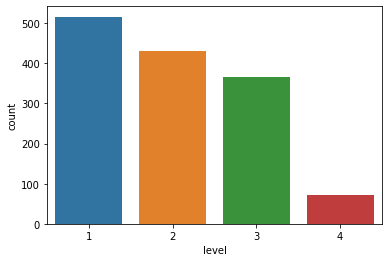

In [98]:
sns.countplot(data=df, x='level');

Tingkat kemacetan direpresentasikan dalam rentang 0--5. Semakin tinggi, kemacetan semakin parah. Klasifikasi ini dilakukan oleh Waze dengan detail sbb:
* 0 = free flow speed -- 80% of free flow speed (lancar)
* 1 = 80% -- 61% of free flow speed
* 2 = 60% -- 41% of free flow speed
* 3 = 40% -- 21% of free flow speed
* 4 = 20 -- 1% of free flow speed
* 5 = blocked road

Berdasarkan visualisasi di atas, mayoritas kemacetan yang terjadi di Kota Banjar antara tanggal 6 Juli 2022 hingga 6 September 2022 tidak terlalu parah (level 1 dan 2).

### Distribusi panjang kemacetan, jeda perjalanan, dan kecepatan kendaraan

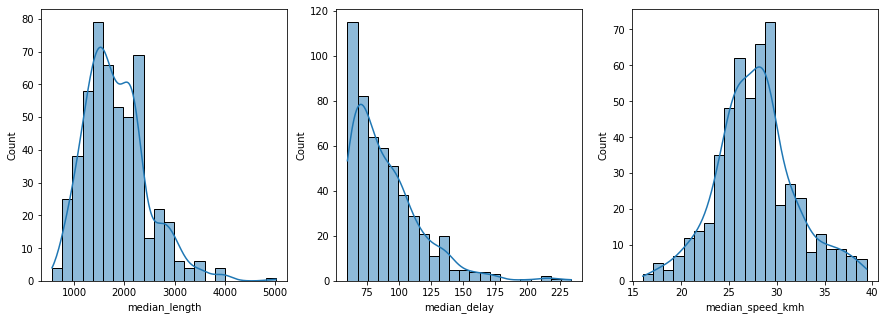

In [99]:
nums = ['median_length', 'median_delay', 'median_speed_kmh']

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 1], kde=True, ax=ax)


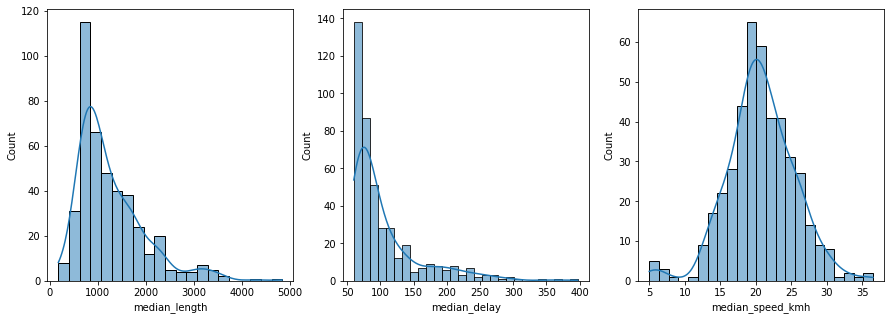

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 2], kde=True, ax=ax)

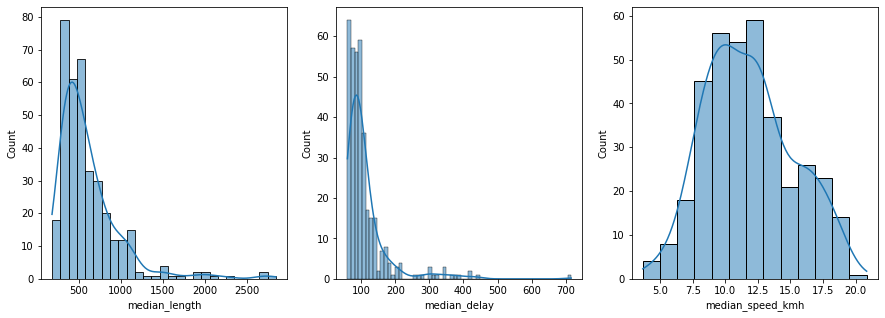

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 3], kde=True, ax=ax)

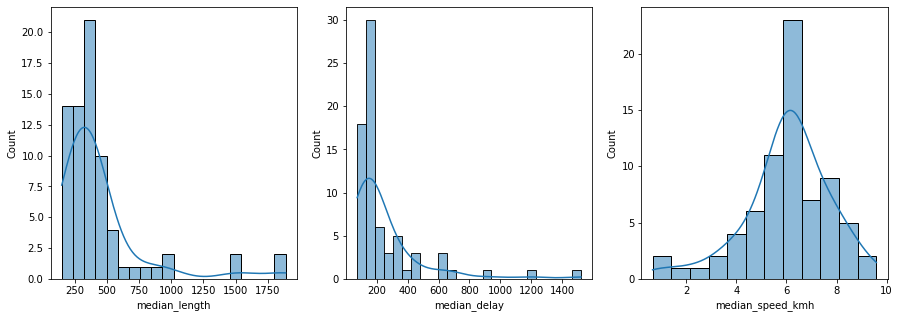

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for num, ax in zip(nums, axes.flatten()):
  sns.histplot(df[num][df['level'] == 4], kde=True, ax=ax)

Berdasarkan visualisasi di atas, panjang kemacetan (`median_length` dalam meter) dan jeda perjalanan akibat kemacetan (`median_delay` dalam detik) untuk tiap tingkat kemacetan masing-masing jarang mencapai 2 km ataupun 250 detik. Kemudian, semakin tinggi tingkat kemacetan, kecepatan kendaraan pun semakin lambat.

Pemodelan akan dilakukan untuk memahami faktor yang paling berkaitan dengan tingkat kemacetan di Kota Banjar berdasarkan lokasi (jalan) dan waktu (hari dan jam). Untuk membantu hal ini, kolom baru yang memuat hanya informasi hari (`dayofweek`) dan jam (`hour`) dibuat. 

In [103]:
df['dayofweek'] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.time

In [104]:
df.head()

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry,dayofweek,hour
0,2022-07-06 02:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,2201.0,84.0,29.779999,6,33489989,2022-07-06,1.0,"MULTILINESTRING ((108.470602 -7.350802, 108.47...",Wednesday,02:00:00
1,2022-07-06 06:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,87.0,10.670000,1,33489990,2022-07-06,3.0,"LINESTRING (108.541986 -7.369257, 108.541931 -...",Wednesday,06:00:00
2,2022-07-06 07:00:00,32.79,KOTA BANJAR,N15 Siliwangi,2,1637.0,110.0,27.110000,7,33489992,2022-07-06,2.0,"MULTILINESTRING ((108.566017 -7.359884, 108.56...",Wednesday,07:00:00
3,2022-07-06 07:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,65.5,12.035000,2,33489991,2022-07-06,3.0,"LINESTRING (108.541068 -7.374205, 108.541374 -...",Wednesday,07:00:00
4,2022-07-06 09:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,2,501.0,63.5,12.705000,2,33489995,2022-07-06,2.0,"LINESTRING (108.541931 -7.369831, 108.541986 -...",Wednesday,09:00:00


Dilakukan feature engineering untuk mendapatkan kategori kemacetan parah dan tidak parah. Kemacetan dengan level di atas 2 dikategorikan sebagai kemacetan parah.

In [105]:
df['is_severe'] = df['level'].apply(lambda x: 1 if x > 2 else 0)

In [106]:
df.head()

,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry,dayofweek,hour,is_severe
0,2022-07-06 02:00:00,32.79,KOTA BANJAR,N13 Jalan Raya Ciamis-Banjar,1,2201.0,84.0,29.779999,6,33489989,2022-07-06,1.0,"MULTILINESTRING ((108.470602 -7.350802, 108.47...",Wednesday,02:00:00,0
1,2022-07-06 06:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,87.0,10.670000,1,33489990,2022-07-06,3.0,"LINESTRING (108.541986 -7.369257, 108.541931 -...",Wednesday,06:00:00,1
2,2022-07-06 07:00:00,32.79,KOTA BANJAR,N15 Siliwangi,2,1637.0,110.0,27.110000,7,33489992,2022-07-06,2.0,"MULTILINESTRING ((108.566017 -7.359884, 108.56...",Wednesday,07:00:00,0
3,2022-07-06 07:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,3,561.0,65.5,12.035000,2,33489991,2022-07-06,3.0,"LINESTRING (108.541068 -7.374205, 108.541374 -...",Wednesday,07:00:00,1
4,2022-07-06 09:00:00,32.79,KOTA BANJAR,N13 Letjen Soewarto,2,501.0,63.5,12.705000,2,33489995,2022-07-06,2.0,"LINESTRING (108.541931 -7.369831, 108.541986 -...",Wednesday,09:00:00,0


## Split Data

Karena pemodelan ini dilakukan untuk memahami kemacetan yang terjadi di Kota Banjar pada tanggal 6 Juli 2022 -- 6 September 2022 (diagnostic analytics), splitting hanya dilakukan untuk mendapatkan X dan y.

In [107]:
# Split antara features dan target variable
features = ['street', 'dayofweek', 'hour']
target = 'is_severe'

X = df[features]
y = df[target]

## Iterate and Evaluate

Karena target variable-nya merupakan categorical data, akan dilakukan pemodelan klasifikasi, yakni logistic regression, decision tree, dan random forest (ensemble model dari decision tree). Model dengan akurasi tertinggi dianggap sebagai model terbaik yang dapat menjelaskan faktor yang paling berkaitan dengan kemacetan di Kota Banjar pada waktu yang telah disebutkan.

###Model 1: Logistic regression

In [108]:
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [109]:
#Model fitting
lr = make_pipeline(OneHotEncoder(),
                   LogisticRegression(max_iter=1000))
lr.fit(X, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [110]:
def acc(model):
  print("Accuracy:", round(model.score(X,y), 3)) 

In [111]:
#Model accuracy
acc(lr)

Accuracy: 0.79


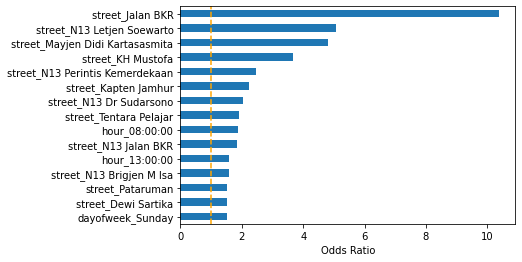

In [112]:
#Explaining model
features_ = lr.named_steps['onehotencoder'].get_feature_names_out()
importances = lr.named_steps['logisticregression'].coef_[0]

odds_ratios = pd.Series(np.exp(importances), index=features_).sort_values()

odds_ratios[-15:].plot(kind='barh') #tail
plt.xlabel('Odds Ratio')
plt.axvline(1.0, color='orange', linestyle='--')

Pemodelan menggunakan logistic regression dengan parameter default memiliki akurasi 79%. Visualisasi di atas menjelaskan seberapa besar kemungkinan terjadinya kemacetan parah jika terdapat kondisi (feature) tertentu. Dari visualisasi ini, diketahui bahwa kemacetan parah paling mungkin terjadi di Jalan BKR. Kebanyakan feature teratas lainnya pun merupakan nama jalan.

###Model 2: Decision tree

In [113]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [114]:
#Model fitting
dtc = make_pipeline(OrdinalEncoder(),
                    DecisionTreeClassifier(random_state=42))
dtc.fit(X, y)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [115]:
#Model accuracy
acc(dtc)

Accuracy: 0.864


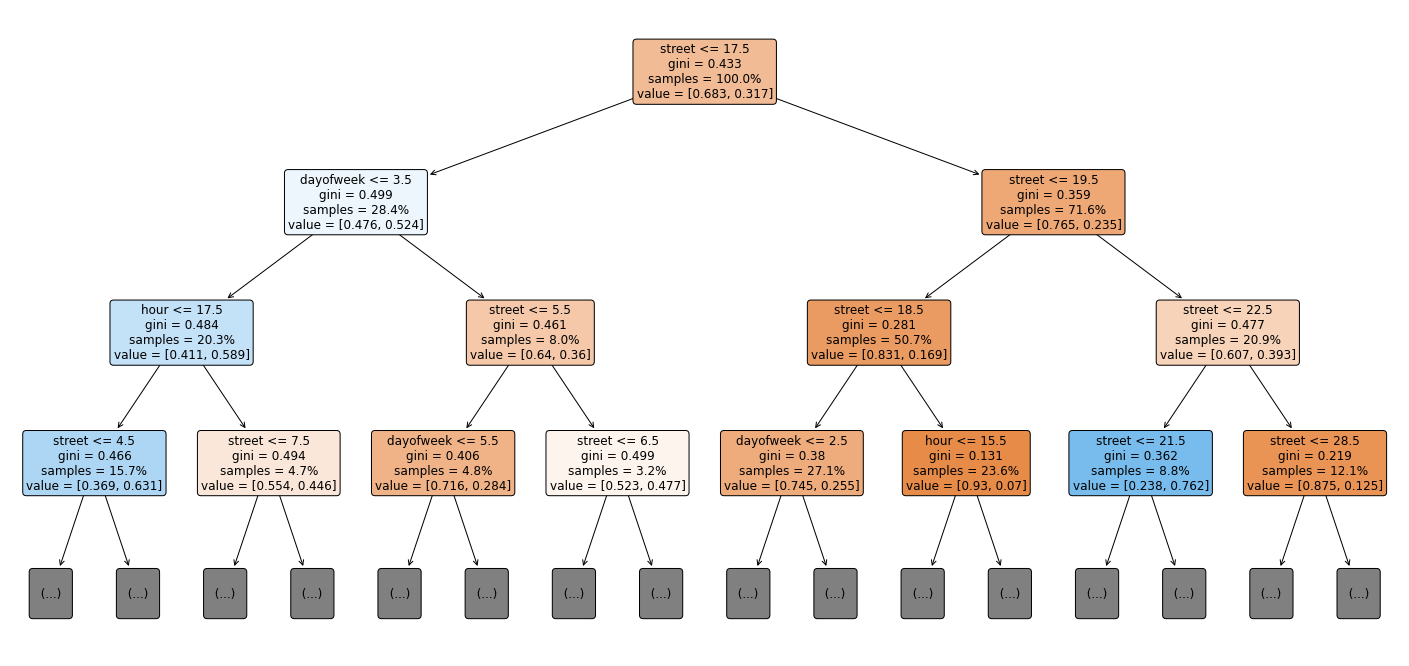

In [116]:
#Explaining model
fig, ax = plt.subplots(figsize=(25, 12))

plot_tree(
    decision_tree= dtc.named_steps['decisiontreeclassifier'],
    feature_names= X.columns,
    filled=True,  
    rounded=True,  
    proportion=True,  
    max_depth=3,  
    fontsize=12, 
    ax=ax, 
);

Pemodelan dengan decision tree memiliki akurasi 86%. Visualisasi di atas menjelaskan bagaimana decision tree memutuskan jenis kemacetan dari kondisi-kondisi (features) yang ada. Sejalan dengan hasil logistic regression, root node dan mayoritas decision nodes teratas pada decision tree ini pun merupakan jalan.

###Model 3: Random forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

In [118]:
#Model fitting
rfc = make_pipeline(OrdinalEncoder(),
                    RandomForestClassifier(random_state=42))
rfc.fit(X, y)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [119]:
#Model accuracy
acc(rfc)

Accuracy: 0.864


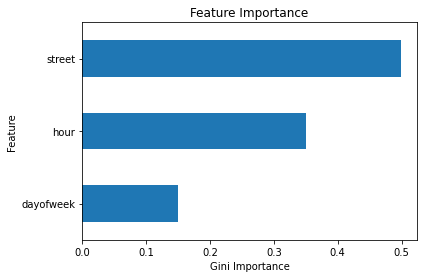

In [120]:
#Explaining model
features_ = X.columns
importances = rfc.named_steps['randomforestclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=features_).sort_values(ascending=True)

feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

Model random forest memiliki akurasi yang sama dengan decision tree dalam menentukan jenis kemacetan di Kota Banjar. Berdasarkan visualisasi di atas, diketahui bahwa lokasi (jalan) adalah faktor yang paling menentukan tingkat kemacetan di Kota Banjar, disusul oleh jam. Sementara itu, hari tidak memiliki bobot yang tinggi (tidak ada kecenderungan kuat antara hari dan tingkat kemacetan tertentu). Hal ini juga dapat diamati pada model lainnya.

##Takeaways
* Jalan memiliki peran yang besar dalam menentukan jenis kemacetan yang terjadi
* Jalan BKR, Letjen Soewarto, dan Mayjen Didi Kartasasmita merupakan 3 jalan yang paling mungkin mengalami kemacetan parah (level lebih dari 2)
* Perlu dilakukan survey lebih lanjut untuk mengetahui penyebab konkret dari kemacetan parah yang terjadi di jalan-jalan tersebut